# Optimisation & Simulation: Lab on MCMC methods

**Objective:**
- Use Markov chain Monte Carlo (MCMC) methods to draw from complex distributions.

**Implementation:**
- Gibbs sampling
- Metropolis-Hastings algorithm

**Agenda:**
1. Implement Gibbs sampler to generate draws from bivariate normal.
2. Implement Metropolis-Hastings algorithms to infer posterior distribution of parameters of Cauchy distribution. 

## Gibbs sampling

### Background

**Motivation and intuition:**
- Draw from multivariate distributions from which direct sampling is difficult.
- Construct conditional distributions from which sampling is easy. 
- Iteratively draw from conditional distributions. 


- Suppose we wish to sample $\theta_{1}, \theta_{2} \sim p(\theta_{1}, \theta_{2})$ but cannot do so directly. 
- However, we can sample $\theta_{1} \sim p(\theta_{1} \vert \theta_{2})$ and $\theta_{2} \sim p(\theta_{2} \vert \theta_{1})$.

**Algorithm:**
1. Set $j = 0$. 
2. Provide initial values $(\theta_{1}^{(0)}, \theta_{2}^{(0)})$. 
3. Set $j = j + 1$. 
4. $\theta_{1}^{(j)} \sim p(\theta_{1}^{(j)} \vert \theta_{2}^{(j-1)})$.
5. $\theta_{2}^{(j)} \sim p(\theta_{2}^{(j)} \vert \theta_{1}^{(j)})$.
6. If $j$ is less than the desired number of draws, return to step 3.

### Exercise
- Implement a Gibbs sampler to draw from a bivariate normal, i.e. 
$$
\begin{pmatrix}
\theta_{1} \\ \theta_{2}
\end{pmatrix}
\sim
\mathcal{N} (\boldsymbol{\mu}, \boldsymbol{\Sigma})
\text{ with }
\boldsymbol{\mu} = \boldsymbol{0},
\boldsymbol{\Sigma} = 
\begin{pmatrix}
1 & \rho \\
\rho & 1 
\end{pmatrix},
\rho = 0.8
$$
- Visually compare the empirical density of the draws to the theoretical density of the sampling distribution. 

**Note:**
- If
$$
\begin{pmatrix}
\theta_{1} \\ \theta_{2}
\end{pmatrix}
\sim
\mathcal{N} \left (\boldsymbol{0}, 
\begin{pmatrix}
1 & \rho \\
\rho & 1 
\end{pmatrix}
\right ),
$$
then 
$$
\theta_{1} \vert \theta_{2} \sim \mathcal{N}(\rho \theta_{2}, 1 - \rho^{2}),
$$
$$
\theta_{2} \vert \theta_{1} \sim \mathcal{N}(\rho \theta_{1}, 1 - \rho^{2}).
$$

#### Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

In [2]:
import numpy as np

def gibbs(rho, theta2_initial, n_draws):
    """ Gibbs sampling of bivariate normal.

    Keywords:
        rho (float): correlation parameter.
        theta2_initial (float): initial value of theta2.
        n_draws (int): number of draws.

    Returns:
        theta (array): draws from bivariate normal.
    """
    theta1 = 0  # Initial value for theta1
    theta2 = theta2_initial
    draws = np.zeros((n_draws, 2))  # To store the draws
    
    for j in range(n_draws):
        theta1 = np.random.normal(rho * theta2, np.sqrt(1 - rho**2))  # Update theta1 given theta2
        theta2 = np.random.normal(rho * theta1, np.sqrt(1 - rho**2))  # Update theta2 given new theta1
        draws[j, :] = [theta1, theta2]  # Store the draws
    
    return draws


In [3]:
rho = 0.8
theta2 = 0
n_draws = 1000

draws = gibbs(rho, theta2, n_draws)

/var/folders/9k/8nb0sdgx5qx6cn2w26k8rd_80000gp/T/ipykernel_9613/3211403608.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(


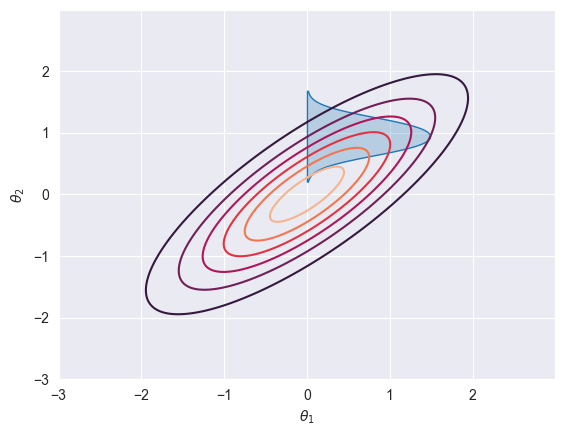

In [4]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

#Theoretical density
mu = np.array([0, 0])
Sigma = np.array([[1, rho], [rho, 1]])
x = np.arange(-3,3,0.01)
xx, yy = np.meshgrid(x,x)
z = multivariate_normal.pdf(np.stack((xx, yy), axis=2), mu, Sigma)
ax.contour(x, x, z)

#Empirical draws
ax = sns.kdeplot(
    draws[0,:], y=draws[1,:],
    cmap= "Blues" , shade = True
)

ax.set(
    xlabel=r'$\theta_1$',
    ylabel=r'$\theta_2$'
)

plt.show()

## Metropolis-Hastings algorithm

### Background

**Motivation and intuition:**
- Gibbs sampling is only feasible, if the conditional distributions are known and if it is easy to sample from them. 
- The Metropolis-Hastings algorithm allows us to sample from any density $p(\theta)$, provided that we can evaluate $f(\theta)$, a density that is proportional to $p$. 
- At each iteration, we sample a new state from a candidate distribution, which depends on the current state. 
- With some probability depending on the value of the target density at the new and the current states, the new state is accepted. 
- As the algorithm proceeds, the sampled states approximate the desired density. 

**Algorithm:**
1. Set $j = 0$.
2. Let $\theta$ denote the current state.
3. Let $p(\theta \vert x)$ denote the target density.
4. Let $J(\theta^{*} \vert \theta)$ denote the jumping distribution
5. Let $\rho$ denote the step size.
6. Set $j = j + 1$. 
7. Propose a new state $\theta^{*} \vert \theta \sim J(\theta)$.
8. Calculate $\alpha = \frac{p(\theta^{*} \vert x)}{p(\theta \vert x)} \cdot \frac{J(\theta \vert \theta^{*})}{J(\theta^{*} \vert \theta)}$.
9. Draw $r \sim \text{Uniform}(0,1)$.
10. If $r \leq \alpha$, accept the new state and set $\theta = \theta^{*}$. Otherwise, reject the new state. 
11. If $j$ is less than the desired number of draws, return to step 5.

### Exercise 
- Simulate data from Cauchy distribution with location $\mu = 1$ and scale $\gamma = 1$.
- Implement a Metroplis-Hastings algorithms to infer the posterior distribution of the scale parameter of the Cauchy distribution.
- Consider two possible jumping distributions:
- 1. $\text{Normal}(\theta, \rho^2)$, where $\rho$ is the step size.
- 2. $\text{Lognormal}(\log(\theta) - 0.5 \rho^2, \rho)$, where $\rho$ is a distance parameter. Note that $\text{Lognormal}(\mu, \sigma)$ denotes a lognormal distribution with location $\mu$ and scale $\sigma$.
- Evaluate the performance of the algorithms for different parametrisations of the jumping distributions. Compute the potential scale reduction factors $\hat{R}$ and the effective sample size $n_{\text{eff}}$.

Suppose
- $x_{i} \sim \mathcal{C}(\mu, \gamma)$ for $i \in \{1, \dots, N\}$
- $\gamma \sim \text{Gamma}(\alpha_{0}, \beta_{0})$ with $\alpha_{0} = \beta_{0} = 0.001$.

Then
$$
p(\gamma \vert x, \mu, \alpha_{0}, \beta_{0}) 
\propto \left ( \prod_{i} p(x_{i} \vert \mu, \gamma) \right ) p(\gamma \vert \alpha_{0}, \beta_{0})
$$

**Note:**
- PDF of Cauchy distribution:
$$
f(x \vert \mu, \gamma) = \frac{1}{\pi \gamma \left [ 1 + \left (\frac{x - \mu}{\gamma} \right )^{2} \right ]}
$$
- Quantile function of Cauchy distribution:
$$
Q = \mu + \gamma \cdot \text{tan}\left [ \pi \left ( F - \frac{1}{2} \right ) \right ]
$$

#### Cauchy random draws

#### Normal jumping distribution
##### Implementation

In [5]:
def cauchy_rng(mu, gamma, n_draws):
    """ Generate cauchy random numbers.
    
    Keywords:
        mu (float): location parameter.
        gamma (float): scale parameter.
        n_draws (int): number of draws.
    
    Returns:
        r (array): n_draws draws from Cauchy(mu, gamma).
    """
    u = np.random.rand(n_draws,)
    r = mu + gamma * np.tan(np.pi * (u - 0.5))
    return r
def cauchy_pdf(x, mu, gamma):
    return 1 / (np.pi * gamma * (1 + ((x - mu) / gamma)**2))

In [6]:
mu = 1
gamma_true = 1
n_draws = 1000
x = cauchy_rng(mu, gamma_true, n_draws)

In [7]:
def rhat_n_eff(draws):
    """ Computes potential scale reduction factor and effective sample size.
    
    Keywords:
        draws (1d-array): draws
    
    Returns:
        R (float): potential scale reduction factor.
        n_eff (float): effective sample size.
    """
    #Reshape draws
    psi_cd = np.array(draws).reshape(2,-1)
    C, D = psi_cd.shape
    
    #Rhat
    psi_c = psi_cd.mean(axis=1, keepdims=True)
    psi = psi_c.mean()
    B = D / (C - 1) * np.sum((psi_c - psi)**2) #Between-chain variance
    s2_c = 1 / (D - 1) * np.sum((psi_cd - psi_c)**2, axis=1)
    W = s2_c.mean() #Within-chain variance
    var = (D - 1) / D * W + 1 / D * B
    R = np.sqrt(var / W)
    
    #Effective sample size
    V = lambda t: ((psi_cd[:,t:] - psi_cd[:,:(D-t)])**2).sum() / (C * (D - t)) #Variogram
    negative_autocorr = False
    t = 1
    rho = np.ones(D)
    while not negative_autocorr and (t < D):
        rho[t] = 1 - V(t) / (2 * var)
        if not t % 2:
            negative_autocorr = np.sum(rho[t-1:t+1]) < 0
        t += 1
    n_eff = C * D / (1 + 2 * np.sum(rho[1:t]))
    
    return R, n_eff

In [8]:
def mcmc_normal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep):
    """ MCMC algorithm with normal jumping distribution to estimate posterior of Cauchy scale parameter.
    
    Keywords:
        x (array): data.
        mu (float): Cauchy location parameter.
        gamma (float): Cauchy scale parameter.
        alpha0 (float): Gamma shape, gamma ~ Gamma(alpha0, beta0).
        beta0 (float): Gamma rate, gamma ~ Gamma(alpha0, beta0).
        rho (float): step size.
        n_burn (int): burn in draws.
        n_keep (int): number of draws to keep after burn-in. 
    
    Returns:
        gamma_store (array): gamma draws.
        accept_store (array): accept flags.
    """
    
    gamma_store= np.zeros(n_burn + n_keep)
    accept_store= np.zeros(n_burn + n_keep)
    
    
    theta = gamma
    Log_J = np.sum(np.log(cauchy_pdf(x, mu, theta)))


    for i in range(n_burn + n_keep):
    #     #  Propose a new state by drawing from the jumping distribution
    # 
        state_new = np.random.normal(theta, rho)
    #     
        Log_J_new = np.sum(np.log(cauchy_pdf(x, mu, state_new)))
    # 
        log_p_ratio=(alpha0-1)*(np.log(state_new)-np.log(theta))-beta0*(state_new-theta)
        ratio = log_p_ratio + Log_J_new - Log_J

        alpha = np.min([0, ratio])
        r = np.random.uniform()
        if np.log(r) < alpha:
            theta = state_new
            Log_J = Log_J_new
            accept_store[i] = True
        gamma_store[i] = state_new
        i += 1

    return gamma_store[n_burn:], accept_store[n_burn:] 

In [9]:
mu = 1
gamma = 0.1
alpha0 = 0.001
beta0 = 0.001
rho = 0.1
n_burn = 1000
n_keep = 1000

gamma_store, accept_store= mcmc_normal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)

/var/folders/9k/8nb0sdgx5qx6cn2w26k8rd_80000gp/T/ipykernel_9613/4128656528.py:32: RuntimeWarning: invalid value encountered in log
  Log_J_new = np.sum(np.log(cauchy_pdf(x, mu, state_new)))
/var/folders/9k/8nb0sdgx5qx6cn2w26k8rd_80000gp/T/ipykernel_9613/4128656528.py:34: RuntimeWarning: invalid value encountered in log
  log_p_ratio=(alpha0-1)*(np.log(state_new)-np.log(theta))-beta0*(state_new-theta)


In [10]:
gamma_store.mean()

0.9773251741568154

In [11]:
gamma_store.std()

0.10983784684949172

In [12]:
accept_store.mean()

0.465

In [13]:
rhat_n_eff(gamma_store)

(0.9996616569307042, 224.35689169514305)

In [14]:
rho_test = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.5, 1]

gamma_store_all = {}
gamma_mean = []
gamma_std = []
gamma_accept = []
gamma_rhat = []
gamma_n_eff = []

for rho in rho_test:
    gamma_store, accept_store = mcmc_normal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)
    rhat, n_eff = rhat_n_eff(gamma_store)
    
    gamma_store_all[rho] = gamma_store
    gamma_mean.append(gamma_store.mean())
    gamma_std.append(gamma_store.std())
    gamma_accept.append(accept_store.mean())
    gamma_rhat.append(rhat)
    gamma_n_eff.append(n_eff)

/var/folders/9k/8nb0sdgx5qx6cn2w26k8rd_80000gp/T/ipykernel_9613/4128656528.py:32: RuntimeWarning: invalid value encountered in log
  Log_J_new = np.sum(np.log(cauchy_pdf(x, mu, state_new)))
/var/folders/9k/8nb0sdgx5qx6cn2w26k8rd_80000gp/T/ipykernel_9613/4128656528.py:34: RuntimeWarning: invalid value encountered in log
  log_p_ratio=(alpha0-1)*(np.log(state_new)-np.log(theta))-beta0*(state_new-theta)


In [15]:
results = pd.DataFrame(
    data={
        'rho': rho_test,
        'Post. mean': gamma_mean,
        'Post. std.': gamma_std,
        'Acceptance ratio': gamma_accept,
        'Rhat': gamma_rhat,
        'n_eff': gamma_n_eff
    }
)
results

,rho,Post. mean,Post. std.,Acceptance ratio,Rhat,n_eff
0,0.00001,0.100822,0.000167,0.967,1.083843,3.691495
1,0.00010,0.132875,0.005860,0.815,2.677647,1.368003
2,0.00100,0.504866,0.056441,0.819,2.190479,1.593021
3,0.01000,0.982534,0.037392,0.948,1.110446,7.121023
4,0.10000,0.975537,0.111392,0.440,0.999488,435.755837
5,0.15000,0.979548,0.145968,0.364,1.000023,771.944397
6,0.20000,0.994197,0.208423,0.286,1.009201,607.848579
7,0.25000,0.980820,0.255202,0.205,0.999001,908.922929
8,0.50000,0.976219,0.502742,0.104,0.999369,1095.116310
9,1.00000,0.977783,0.952697,0.062,0.999049,1059.186612


##### Trace plot

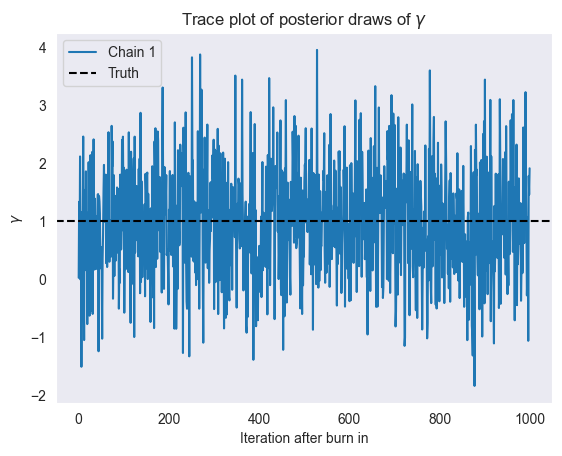

In [16]:
gamma_true = 1

fig, ax = plt.subplots(1,1)
ax.plot(gamma_store_all[1], label = 'Chain 1')
plt.axhline(gamma_true, color="black", linestyle="--", label='Truth')

ax.set(xlabel = 'Iteration after burn in', ylabel = r'$\gamma$',
       title= r'Trace plot of posterior draws of $\gamma$')
plt.legend()
ax.grid()

#### Lognormal jumping distribution
##### Implementation

In [17]:
def mcmc_lognormal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep):
    """ MCMC algorithm with lognormal jumping distribution to estimate posterior of Cauchy scale parameter.
    
    Keywords:
        x (array): data.
        mu (float): Cauchy location parameter.
        gamma (float): Cauchy scale parameter.
        alpha0 (float): Gamma shape, gamma ~ Gamma(alpha0, beta0).
        beta0 (float): Gamma rate, gamma ~ Gamma(alpha0, beta0).
        rho (float): step size.
        n_burn (int): burn in draws.
        n_keep (int): number of draws to keep after burn-in. 
    
    Returns:
        gamma_store (array): gamma draws.
        accept_ store (array): accept flags.
    """

    gamma_store = np.zeros(n_burn+n_keep)
    accept_store = np.zeros(n_burn + n_keep)
    theta = gamma
    Log_J = np.sum(np.log(cauchy_pdf(x, mu, theta)))
    
    # MCMC sampling
    for i in range(n_burn + n_keep):
    #    Propose a new state by drawing from the jumping distribution
    # 
        state_new = np.random.lognormal(np.log(theta) - 0.5 * rho ** 2, rho)
        # 
        Log_J_new = np.sum(np.log(cauchy_pdf(x, mu, state_new))) 
    
        log_p_ratio=(alpha0-1)*(np.log(state_new)-np.log(theta))-beta0*(state_new-theta)
    
        ratio = log_p_ratio + Log_J_new - Log_J

        alpha = np.min([0, ratio])
        r = np.random.uniform()
        if np.log(r) < alpha:
            theta = state_new
            Log_J = Log_J_new
            accept_store[i] = True
        gamma_store[i] = state_new
        i += 1
            
    return gamma_store[n_burn:], accept_store[n_burn:] 


In [26]:
mu = 1
gamma = 0.1
alpha0 = 0.001
beta0 = 0.001
rho = 0.1
n_burn = 1000
n_keep = 1000


CAUCHY_MU_GT: float = 1.0
CAUCHY_GAMMA_GT: float = 1.0
CAUCHY_N_DRAWS: int = 1000
cauchy_draws = cauchy_rng(CAUCHY_MU_GT, CAUCHY_GAMMA_GT, CAUCHY_N_DRAWS)
x = cauchy_draws
gamma_store, accept_store = mcmc_lognormal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)

In [27]:
gamma_store.mean()

0.9863302511695023

In [28]:
gamma_store.std()

0.10641725758851171

In [29]:
accept_store.mean()

0.465

In [30]:
rhat_n_eff(gamma_store)

(1.0039845924793955, 547.7234822646291)

In [31]:
rho_test = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.5, 1]

gamma_store_all = {}
gamma_mean = []
gamma_std = []
gamma_accept = []
gamma_rhat = []
gamma_n_eff = []

for rho in rho_test:
    gamma_store, accept_store = mcmc_lognormal(x, mu, gamma, alpha0, beta0, rho, n_burn, n_keep)
    rhat, n_eff = rhat_n_eff(gamma_store)
    
    gamma_store_all[rho] = gamma_store
    gamma_mean.append(gamma_store.mean())
    gamma_std.append(gamma_store.std())
    gamma_accept.append(accept_store.mean())
    gamma_rhat.append(rhat)
    gamma_n_eff.append(n_eff)

In [32]:
results = pd.DataFrame(
    data={
        'rho': rho_test,
        'Post. mean': gamma_mean,
        'Post. std.': gamma_std,
        'Acceptance ratio': gamma_accept,
        'Rhat': gamma_rhat,
        'n_eff': gamma_n_eff
    }
)
results

,rho,Post. mean,Post. std.,Acceptance ratio,Rhat,n_eff
0,0.00001,0.099985,0.000010,0.997,1.610239,2.351262
1,0.00010,0.100371,0.000234,0.968,2.654592,1.327650
2,0.00100,0.137569,0.007243,0.801,2.190188,1.622846
3,0.01000,0.980687,0.044404,0.930,1.127219,9.165378
4,0.10000,0.984650,0.110332,0.454,0.999006,566.811970
5,0.15000,0.987206,0.154723,0.330,1.001511,577.911187
6,0.20000,0.976925,0.204351,0.247,1.002405,817.197976
7,0.25000,0.986853,0.260002,0.212,1.000306,1076.190676
8,0.50000,0.983742,0.520717,0.114,1.001116,1095.183271
9,1.00000,1.003339,1.258567,0.052,1.000226,923.590106


##### Trace plot

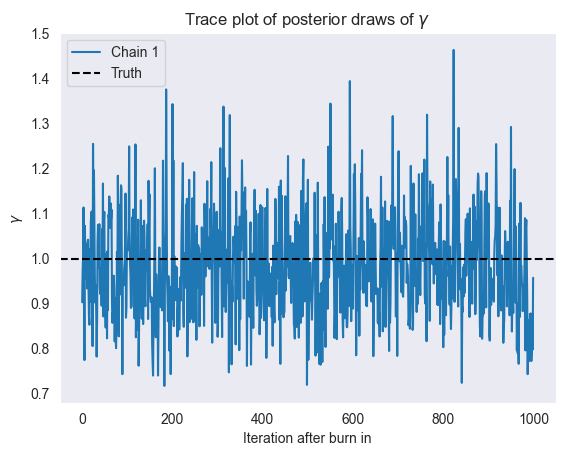

In [33]:
fig, ax = plt.subplots(1,1)
ax.plot(gamma_store_all[0.1], label = 'Chain 1')
plt.axhline(gamma_true, color="black", linestyle="--", label='Truth')

ax.set(xlabel = 'Iteration after burn in', ylabel = r'$\gamma$',
       title= r'Trace plot of posterior draws of $\gamma$')
plt.legend()
ax.grid()